In [ ]:
import pandas as pd
import numpy as np
import os

from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import ee

### Earth Engine

Earth Engine autenticate (usar _franvalent93@gmail.com_)

In [ ]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=KC7OPNJwwjS0IIQ3Z_GtPoC-ZJ54vBs3Km6npdc9Xf0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4anI-7JRSrEiz5TnfIhV0k1ZHJNMe6udT_x_alosJMzfYilAVSL-A

Successfully saved authorization token.


In [ ]:
ee.Initialize()

### Google Drive

GDrive authenticate (usar _ft.valentini@gmail.com_)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Datasets

In [ ]:
URL_TRAIN = \
  'https://raw.githubusercontent.com/ftvalentini/DesafioAgTech2020/master/dataset/data_train.csv'
URL_TEST = \
  'https://raw.githubusercontent.com/ftvalentini/DesafioAgTech2020/master/dataset/data_test.csv'

In [ ]:
dat_train = pd.read_csv(URL_TRAIN, error_bad_lines=False)
dat_test = pd.read_csv(URL_TEST, error_bad_lines=False)

In [ ]:
dat_train.head()

,Id,Cultivo,Longitud,Latitud,Elevacion,Dataset,Campania,GlobalId
0,1,S,-62.144163,-33.800202,104.111862,BC,18/19,1
1,4,M,-62.155418,-33.801742,105.698082,BC,18/19,4
2,6,N,-62.163615,-33.808092,104.233162,BC,18/19,6
3,7,M,-62.164773,-33.813671,103.859932,BC,18/19,7
4,9,M,-62.097200,-33.778628,98.532104,BC,18/19,9


In [ ]:
dat_train.Campania.value_counts()

19/20    556
18/19    294
Name: Campania, dtype: int64

In [ ]:
dat_train.Cultivo.value_counts(dropna=False)

S      344
M      210
s       89
N       82
P       55
X       34
U       12
B        6
R        6
m        4
aa       2
A        2
T        2
G        1
S/M      1
Name: Cultivo, dtype: int64

In [ ]:
# Labels que descartamos
BANNED = ['S/M']
dat_train = dat_train.query("Cultivo not in @BANNED")

## Funciones

In [ ]:
def create_reduce_region_function(
  geometry, reducer=ee.Reducer.mean(), scale=10, crs=None):
  """
  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.
  """
  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer, geometry=geometry, scale=scale, crs=crs, 
        bestEffort=True)
    return ee.Feature(geometry, stat).set(
        {'millis': img.date().millis()
        ,'cloudy_perc': img.get("CLOUDY_PIXEL_PERCENTAGE")
        ,'vegetation_perc': img.get("VEGETATION_PERCENTAGE")
        })
  return reduce_region_function


def fc_to_df(fc):
  """
  Transfer feature collection properties to a DataFrame
  """
  data = fc.getInfo()
  features = data['features']
  dict_list = [f['properties'] for f in features]
  df = pd.DataFrame(dict_list)
  df = add_date_info(df)
  return df


def add_date_info(df):
  """
  Add date variables to DataFrame with millis
  """
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df


def get_stats_df(
    collection, long, lat, fecha_start, fecha_end, dim_buffer=60
    ,reducer=ee.Reducer.mean(), scale=10, crs=None):
  """
  Produce DataFrame de stats para el buffer de un punto en un periodo
  ¿¿QUE CRS USAR?? EL DEFAULT????
    me cruce estos por ahora: 'EPSG:4326','EPSG:32720','EPSG:3310'
  """
  image_collection = collection.filterDate(fecha_start, fecha_end)
  buffer = ee.Geometry.Point([long, lat]).buffer(dim_buffer)
  reduce_image = create_reduce_region_function(
    geometry=buffer, reducer=reducer, scale=scale, crs=crs)
  image_fc = ee.FeatureCollection(image_collection.map(reduce_image))
  image_df = fc_to_df(image_fc)
  return image_df


def clean_df(df, max_cloud_perc=25):
  """
  Limpia el DataFrame de un buffer (saca NaN, filtra por cloud)
  """
  df = df.dropna()
  df = df.query(f"cloudy_perc < {max_cloud_perc}")
  return df


def plot_bandas(
    df, bandas, size=(4,4), black_background=False, y_max=None, heatmap=False):
  """
  Plot bandas over time de data de un df con stats 
  Param:
    - heatmap: plot heatmap of time series
  La paleta salio de:
    R> library(RColorBrewer)
    R> cat(brewer.pal(n=11,"Set3"), sep="','")
  """
  COLORES = \
    ['#8DD3C7','#FFFFB3','#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD','#CCEBC5']
    #['#E41A1C','#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999']
  if black_background:
    plt.style.use('dark_background')
  else:
    plt.style.use('ggplot')
  fig, ax = plt.subplots(figsize=size)
  if heatmap:
    df = df[BANDAS].transpose()
    sns.heatmap(df, cbar=False, vmin=-50, vmax=y_max) # cmap='viridis'
  else:
    for i,b in enumerate(bandas):
      sns.lineplot(data=df, x="Timestamp", y=b, color=COLORES[i], linewidth=3)
      # sns.lineplot(data=df, x="Timestamp", y=b, color=COLORES[i], linewidth=1)
      plt.ylim(-50, y_max)
  plt.axis('off')
  return fig, ax

## Satellite collection

Tiles de https://www.youtube.com/watch?v=ybEvraFKR5Y&ab_channel=MatbaRofexSchool (01:31:45)

In [ ]:
TILES = ['20HPJ','20HNH','20HPH']
BANDAS = ["B1","B2","B3","B4","B5","B6","B7","B8","B9","B11","B12"]

In [ ]:
s2_collection = \
  ee.ImageCollection("COPERNICUS/S2_SR").\
  filter(ee.Filter.inList('MGRS_TILE', TILES)).\
  select(BANDAS).\
  filterDate('2018-01-01', '2020-08-01')

In [ ]:
crs_id = ee.FeatureCollection(s2_collection).getInfo()['features'][0]['bands'][0]['crs']
print(f"el CRS de la 1a banda del primer lote es \n{crs_id}")

el CRS de la 1a banda del primer lote es 
EPSG:32720


## Get data

### Parameters

In [ ]:
EXPERIMENT_ID = "heatmap_ts"

OUTDIR_TRAIN = \
  f"drive/My Drive/MACHINLEARNING/DesafioAgTech2020/data/train_{EXPERIMENT_ID}"
OUTDIR_TEST = \
  f"drive/My Drive/MACHINLEARNING/DesafioAgTech2020/data/test_{EXPERIMENT_ID}" # ts: time series

BANDAS = ["B1","B2","B3","B4","B5","B6","B7","B8", "B9", "B11","B12"] # ejemplo3 alfredo (B,G,R,NIR,SWIR1,SWIR2)
# BANDAS = ["B3","B5","B9","B11","B12"] 
DIM_BUFFER = 60 # m2 alrededor del punto
REDUCER = ee.Reducer.mean()
SCALE = 20 #(?)
CRS = None # None es probablemente lo mismo que crs_id 
FIGSIZE = (4,4)
BLACK_BACKGROUND = True
MIN_VEGETATION_TRAIN = 30 # borra casos if menor a esto en (S,M,s,m)
HEATMAP = True # plot ts as heatmap

# las fechas se fijan en los loops

### Train data

In [ ]:
puntos_train = \
  dat_train[['Longitud','Latitud','Campania','GlobalId','Cultivo']].to_dict('records')

**RUN**

Get DataFrames

In [ ]:
df_list = []

In [ ]:
for p in tqdm(puntos_train):

  # fechas
  anio = int('20' + p['Campania'][-2:])
  fecha_start = str(anio-1)+'-10-01' # anio anterior
  fecha_end = str(anio)+'-07-31' # anio corriente

  # make stats DFrame
  df_ = get_stats_df(
    s2_collection, p['Longitud'], p['Latitud'], fecha_start, fecha_end
    ,dim_buffer=DIM_BUFFER, reducer=REDUCER, scale=SCALE, crs=CRS)
  
  # clean DFrame
  df_clean_ = clean_df(df_)
  df_clean_['id'] = p['GlobalId']

  # bind to full DFrame
  df_list.append(df_clean_)


100%|██████████| 849/849 [35:20<00:00,  2.50s/it]


In [ ]:
df_train = pd.concat(df_list).reset_index(drop=True)

In [ ]:
# save
df_train.to_csv(
    f"drive/My Drive/MACHINLEARNING/DesafioAgTech2020/data/df_train_{EXPERIMENT_ID}.csv"
    ,index=False)

In [ ]:
df_train.sample(1)

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,cloudy_perc,millis,vegetation_perc,Timestamp,Year,Month,Day,DOY,id
20164,1232.134291,3691.289977,2519.525901,1416.336852,1709.039414,2234.769426,2592.984797,2681.473395,2865.590231,3017.236205,3245.075873,18.094363,1587478326122,14.201774,2020-04-21 14:12:06.122,2020,4,21,112,1032


Max value de las bandas para definir limite vertical en los plots

In [ ]:
max_value = df_train[BANDAS].max().max()
print(max_value)

18954.43142214727


#### Make/Save plots

In [ ]:
k = 0
for p in tqdm(puntos_train):

  # output file
  out_folder = Path(OUTDIR_TRAIN) / p['Cultivo']
  os.makedirs(out_folder, exist_ok=True)
  out_file = (out_folder / str(p['GlobalId'])).with_suffix(".png")
  
  # get DFrame
  df_clean_ = df_train.loc[df_train['id'] == p['GlobalId']] 
  
  # pass if low vegetation %
  veg_perc = df_clean_['vegetation_perc'].median()
  if p['Cultivo'] in ('S','M','s') and veg_perc < MIN_VEGETATION_TRAIN:
    pass

  # plot
  fig, ax = plot_bandas(
      df_clean_, BANDAS, size=FIGSIZE, black_background=BLACK_BACKGROUND
      ,y_max=max_value, heatmap=HEATMAP)

  # save plot
  fig.savefig(out_file, bbox_inches='tight', pad_inches=0)
  plt.close(fig) # not show fig
  k += 1

print(f"{k} images saved out of {len(puntos_train)}")

100%|██████████| 849/849 [02:23<00:00,  5.91it/s]

849 images saved out of 849


### Test data

In [ ]:
puntos_test = \
  dat_test[['Longitud','Latitud','Campania','GlobalId']].to_dict('records')

**RUN**

In [ ]:
for p in tqdm(puntos_test):

  # output file
  out_folder = Path(OUTDIR_TEST)
  os.makedirs(out_folder, exist_ok=True)
  out_file = (out_folder / str(p['GlobalId'])).with_suffix(".png")
  
  # fechas
  anio = int('20' + p['Campania'][-2:])
  fecha_start = str(anio-1)+'-10-01' # anio anterior
  fecha_end = str(anio)+'-07-31' # anio corriente

  # make stats DFrame
  df_ = get_stats_df(
    s2_collection, p['Longitud'], p['Latitud'], fecha_start, fecha_end
    ,dim_buffer=DIM_BUFFER, reducer=REDUCER, scale=SCALE, crs=CRS)
  
  # clean DFrame
  df_clean_ = clean_df(df_)

  # plot
  fig, ax = plot_bandas(
      df_clean_, BANDAS, size=FIGSIZE, black_background=BLACK_BACKGROUND
      ,y_max=max_value, heatmap=HEATMAP)

  # save plot
  fig.savefig(out_file, bbox_inches='tight', pad_inches=0)
  plt.close(fig) # not show fig

100%|██████████| 555/555 [26:06<00:00,  2.82s/it]


## Ejemplos individuales

In [ ]:
#dd = pd.read_csv(
#    f"drive/My Drive/MACHINLEARNING/DesafioAgTech2020/data/df_train_ts_fullbandas_conX.csv")
#dd[BANDAS].max().max()

18954.431422147267

**soja**

In [ ]:
long, lat, campania = \
  dat_train.query("Cultivo == 'S'")[['Longitud','Latitud','Campania']].sample(1).iloc[0,:]
anio = int('20' + campania[-2:])
fecha_start = str(anio-1)+'-10-01'
fecha_end = str(anio)+'-07-31'

df1 = get_stats_df(
    s2_collection, long, lat, fecha_start, fecha_end, dim_buffer=60
    ,reducer=ee.Reducer.mean(), scale=20)
df1_clean = clean_df(df1)

long, lat, campania

(-62.025435821189824, -33.583750212376806, '18/19')

In [ ]:
df1_clean['cloudy_perc'].median(), df1_clean['vegetation_perc'].median()

(0.083573, 42.774788)

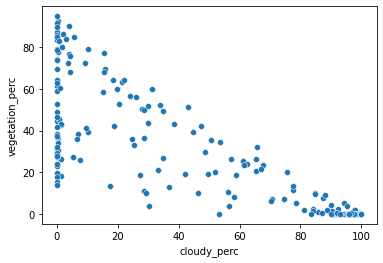

In [ ]:
sns.scatterplot(x=df1['cloudy_perc'], y=df1['vegetation_perc']) # tiene sentido

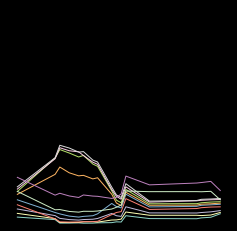

In [ ]:
fig, ax = plot_bandas(df1_clean, BANDAS, black_background=True, y_max=18955)

**soja tardia**

In [ ]:
long, lat, campania = \
  dat_train.query("Cultivo == 'M'")[['Longitud','Latitud','Campania']].sample(1).iloc[0,:]
anio = int('20' + campania[-2:])
fecha_start = str(anio-1)+'-10-01'
fecha_end = str(anio)+'-07-31'

df2 = get_stats_df(
    s2_collection, long, lat, fecha_start, fecha_end, dim_buffer=60
    ,reducer=ee.Reducer.mean(), scale=10, crs='EPSG:3310')
df2_clean = clean_df(df2)

long, lat, campania

(-62.294962416482285, -34.036064073398215, '19/20')

In [ ]:
df2_clean['cloudy_perc'].median(), df2_clean['vegetation_perc'].median()

(0.5380665, 37.009762499999994)

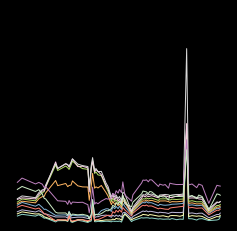

In [ ]:
fig, ax = plot_bandas(df2_clean, BANDAS, black_background=True, y_max=18955)

(0.0, 64.0, 11.0, 0.0)

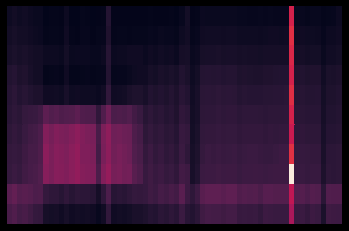

In [ ]:
# aa = df2_clean[BANDAS].transpose()
# sns.heatmap(aa, cbar=False)
# # sns.heatmap(aa, cbar=False, vmin=0, vmax=18955)
# plt.axis('off')

In [ ]:
# plt.style.available

## Notas

Parcialmente inspirado en:

* https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair